In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import fsolve
import astropy.constants as cst
import astropy.units as u
import pandas as pd
from scipy.optimize import root_scalar
from scipy.special import kv as Kv  

# Constantes physiques
m_p = cst.m_p.to('g').value    # masse du proton [g]
m_e = cst.m_e.to('g').value    # masse de l'électron [g]
c = cst.c.to('cm/s').value     # vitesse de la lumière [cm/s]
sigma_T = cst.sigma_T.to('cm^2').value  # section efficace de Thomson [cm^2]
q_e = 4.80320425e-10           # charge de l'électron [esu]



class OnAxisJet:
    def __init__(self):
        # Paramètres du jet article
        self.E_iso = 1e53       # énergie isotrope [erg]
        self.n_0 = 1e-3        # densité du milieu [cm^-3]
        self.epsilon_e = 0.1    # fraction d'énergie dans les électrons
        self.epsilon_B = 1e-4   # fraction d'énergie dans le champ B
        self.p = 2.2            # indice spectral des électrons
        self.theta_obs = 0.0    # angle d'observation (0 = dans l'axe)


    #Facteur de Lorentz du choc basé sur l'interpolation équation (1)
    def gamma_shock(self, t):

      # Coefficients BM et ST
      C_BM = np.sqrt(17 * self.E_iso / (8 * np.pi * self.n_0 * m_p * c**5))  # [s^(-3/2)]
      C_ST = (2/5) * 1.15 * (self.E_iso / (self.n_0 * m_p * c**5))**(1/5)     # [s^(-3/5)]

      # Valeur limite
      Gamma_max = 100

      # Calcul de Gamma beta
      gamma2_beta2 = min((C_BM**2) * t**(-3),(C_ST**2) * t**(-6/5),Gamma_max**2)

      # Calcul de β_shock
      beta_sh = np.sqrt(gamma2_beta2 / (1 + gamma2_beta2))

      # Calcul de Γ_shock
      Gamma_sh = 1 / np.sqrt(1 - beta_sh**2)

      return Gamma_sh



    #Rayon du choc
    def shock_radius(self, t):
        def beta_sh(t_prime):
            Gamma = self.gamma_shock(t_prime)
            if Gamma <= 1:
                return 0.0
            return np.sqrt(1 - 1 / Gamma**2)

        R = c * quad(beta_sh, 0, t)[0]
        return R

    #Propriétés en aval du choc
    def downstream_properties(self, t):
        Gamma_sh = self.gamma_shock(t)

        # Approximation ultra-relativiste (valable pour Gamma_sh >> 1)
        Gamma = Gamma_sh / np.sqrt(2)              # facteur de Lorentz du fluide
        n_prime = 4 * Gamma_sh * self.n_0          # densité en aval [cm^-3]
        e_prime = 4 * Gamma_sh**2 * self.n_0 * m_p * c**2  # densité d'énergie [erg/cm^3]

        return Gamma, n_prime, e_prime


    #Equation 31 t= T + muR/c
    def solve_emission_time(self, T_obs, mu):
      def equation(t):
          R = jet.shock_radius(t)
          return  mu * R / c + T_obs - t
      return fsolve(equation, T_obs)[0]
    
    
    # Résolution numérique de zeta à partir de Gamma (équation 12)
    def compute_zeta(self, Gamma):
        # Énergie interne spécifique
        e_over_nmc2 = Gamma - 1  # e'_i / (n' m_p c^2)

        def equation(zeta):
            # Bessel ratio: h'/mc^2
            if zeta <= 0:
                return 1e10  # éviter les divisions par 0
            h_over_mc2 = Kv(3, zeta) / Kv(2, zeta)
            return h_over_mc2 - 1 / zeta - Gamma  # doit s'annuler

        # Recherche dans un domaine raisonnable
        sol = root_scalar(equation, bracket=[1e-3, 100], method='brentq')
        if sol.converged:
            return sol.root
        else:
            raise RuntimeError("Échec de la convergence pour zeta")

    # Calcul de l'énergie interne spécifique (équation 11)    
    def gamma_hat(self, zeta):
        """Calcule le gamma chapeau en fonction de zeta"""
        K1 = Kv(1, zeta)
        K2 = Kv(2, zeta)
        K3 = Kv(3, zeta)
        
        num = 4 * K2
        denom = zeta * (3 * K3 + K1 - 4 * K2)
        
        gamma_hat = 1 + num / denom
        return gamma_hat



T_obs = 1e5
mu = 0.8

jet = OnAxisJet()
t_emit = jet.solve_emission_time(T_obs, mu)
R_emit = jet.shock_radius(t_emit)
T_check = t_emit - mu * R_emit / c



print(f"Résolution de l'équation 31")
print(f"mu = {mu}")
print(f"T_obs = {T_obs:.2e} s")
print(f"t_emit = {t_emit:.8e} s")
print(f"R(t_emit) = {R_emit:.2e} cm")
print(f"Vérification : t_emit - mu * R / c = {T_check:.2e} s")
%timeit jet.solve_emission_time(T_obs, mu)


Résolution de l'équation 31
mu = 0.8
T_obs = 1.00e+05 s
t_emit = 4.99817785e+05 s
R(t_emit) = 1.50e+16 cm
Vérification : t_emit - mu * R / c = 1.00e+05 s
2.42 ms ± 23.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
#Vérification avec beta(t) = beta0 * t^alpha / (1 + t^alpha), alpha = 1 cas simple
class SimpleBetaJet:
    def __init__(self, beta0=0.5, alpha=1):
        self.beta0 = beta0
        self.alpha = alpha

    def beta(self, t):
        return self.beta0 * t**self.alpha / (1 + t**self.alpha)


    def shock_radius(self, t):
        # Intégration de beta(t) pour obtenir R(t)
        def beta_func(t_prime):
            b = self.beta(t_prime)
            return np.clip(b, 0, 1)  # pour éviter β > 1
        R = c * quad(beta_func, 0, t)[0]
        return R

    def solve_emission_time(self, T_obs, mu):
        def equation(t):
            R = self.shock_radius(t)
            return mu * R / c + T_obs - t
        return fsolve(equation, T_obs)[0]

In [46]:
T_obs = 1e5
mu = 0.8

# Bien forcer la recréation de l'objet
jet_poly = SimpleBetaJet(beta0=0.5, alpha=1)

# Affiche la valeur de beta
print("beta(1e5) =", jet_poly.beta(1e5))

# Résout t_emit
t_emit_poly = jet_poly.solve_emission_time(T_obs, mu)
R_emit_poly = jet_poly.shock_radius(t_emit_poly)
T_check_poly = t_emit_poly - mu * R_emit_poly / c

# Affiche résultats
print(f"Test avec β(t) polynomial")
print(f"mu = {mu}")
print(f"T_obs = {T_obs:.2e} s")
print(f"t_emit = {t_emit_poly:.8e} s")
print(f"R(t_emit) = {R_emit_poly:.4e} cm")
print(f"Vérification : t_emit - mu * R / c = {T_check_poly:.5e} s")


beta(1e5) = 0.4999950000499995
Test avec β(t) polynomial
mu = 0.8
T_obs = 1.00e+05 s
t_emit = 1.66658651e+05 s
R(t_emit) = 2.4980e+15 cm
Vérification : t_emit - mu * R / c = 1.00000e+05 s


C:\Users\Sourya\AppData\Local\Temp\ipykernel_37828\1270490146.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


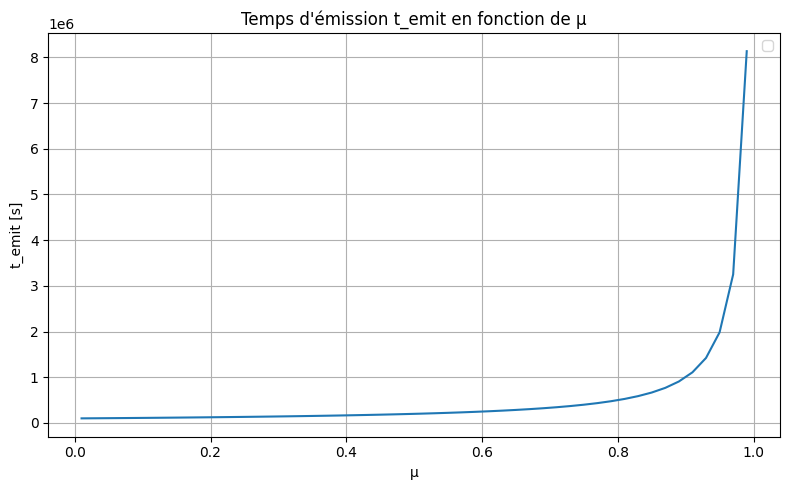

In [47]:
#Figure avec mu qui varie 
T_obs = 1e5
mu_values = np.linspace(0.01, 0.99, 50)

jet = OnAxisJet()
t_emit_values = [jet.solve_emission_time(T_obs, mu) for mu in mu_values]

plt.figure(figsize=(8, 5))
plt.plot(mu_values, t_emit_values)
plt.xlabel('μ')
plt.ylabel('t_emit [s]')
plt.title('Temps d\'émission t_emit en fonction de μ')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [48]:
#Tableau avec mu qui varie de 0 à 1
T_obs = 1e5
mu_values = np.round(np.linspace(0, 1, 11), 2)
jet = OnAxisJet()

# Calcul des temps d'émission
t_emit_values = []
for mu in mu_values:
    t_emit = jet.solve_emission_time(T_obs, mu)
    t_emit_values.append(t_emit)

# Création de la table
df = pd.DataFrame({
    "mu": mu_values,
    "t_emit (s)": np.round(t_emit_values, 3)
})

print(df)

     mu    t_emit (s)
0   0.0  1.000000e+05
1   0.1  1.111105e+05
2   0.2  1.249984e+05
3   0.3  1.428541e+05
4   0.4  1.666611e+05
5   0.5  1.999899e+05
6   0.6  2.499796e+05
7   0.7  3.332833e+05
8   0.8  4.998178e+05
9   0.9  9.982734e+05
10  1.0  1.743777e+07


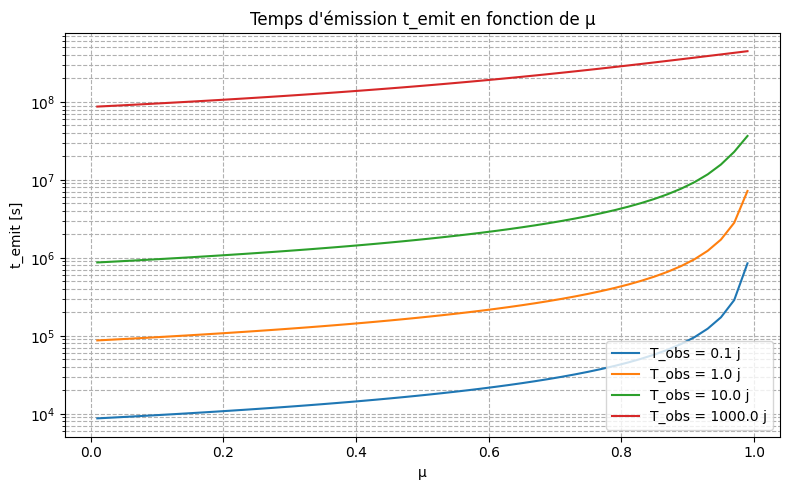

In [49]:
# Figure 1 : t_emit en fonction de mu 
jours = np.array([0.1, 1, 10, 1000])
T_values = jours * 24 * 3600
mu_values = np.linspace(0.01, 0.99, 50)

plt.figure(figsize=(8, 5))
for T in T_values:
 jet = OnAxisJet()
 t_emit_values = [jet.solve_emission_time(T, mu) for mu in mu_values]
 plt.plot(mu_values, t_emit_values, label=f'T_obs = {T/86400:.1f} j')
plt.xlabel('μ')
plt.ylabel('t_emit [s]')
plt.title('Temps d\'émission t_emit en fonction de μ')
plt.yscale('log')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

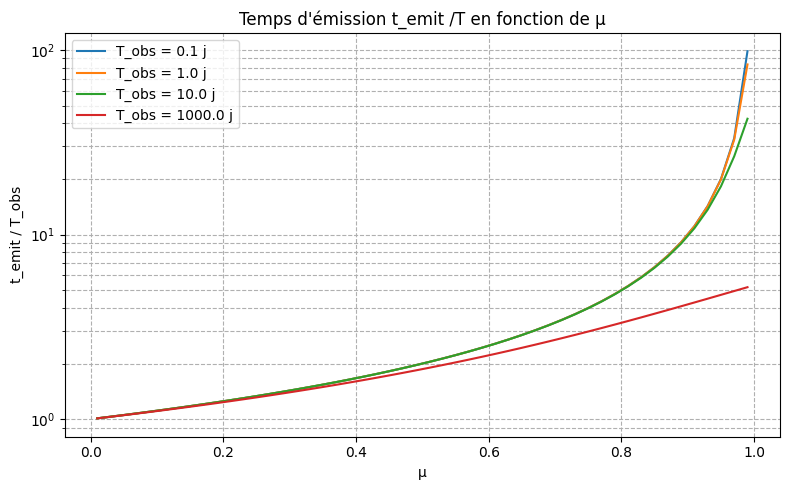

In [50]:
# Figure 2 : t_emit / T en fonction de mu
plt.figure(figsize=(8, 5))
for T in T_values:
 jet = OnAxisJet()
 t_emit_values = [jet.solve_emission_time(T, mu)/T for mu in mu_values]
 plt.plot(mu_values, t_emit_values, label=f'T_obs = {T/86400:.1f} j')
plt.xlabel('μ')
plt.ylabel('t_emit / T_obs')
plt.title('Temps d\'émission t_emit /T en fonction de μ')
plt.yscale('log')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

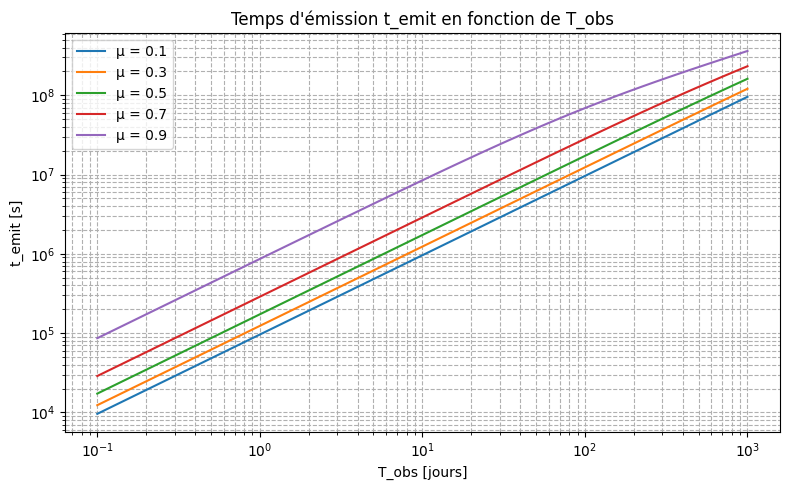

In [51]:
# Figure 3 : t_emit en fonction de T_obs pour différents mu
jours = np.logspace(-1, 3, 50) # de 0.1 à 1000 jours, échelle log
T_values = jours * 24 * 3600 # en secondes
mu_list = [0.1, 0.3, 0.5, 0.7, 0.9]

plt.figure(figsize=(8, 5))
for mu in mu_list:
 jet = OnAxisJet()
 t_emit_values = [jet.solve_emission_time(T, mu) for T in T_values]
 plt.plot(T_values / 86400, t_emit_values, label=f'μ = {mu}') # T en jours

plt.xlabel('T_obs [jours]')
plt.ylabel('t_emit [s]')
plt.title('Temps d\'émission t_emit en fonction de T_obs')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

In [52]:
#Test méthode zeta
Gamma_fluid, n_prime, e_prime = jet.downstream_properties(t_emit)
zeta = jet.compute_zeta(Gamma_fluid)

print("\n--- Résolution numérique de zeta ---")
print(f"Gamma_fluid = {Gamma_fluid:.5f}")
print(f"zeta = {zeta:.5f}")


--- Résolution numérique de zeta ---
Gamma_fluid = 4.48048
zeta = 0.71623


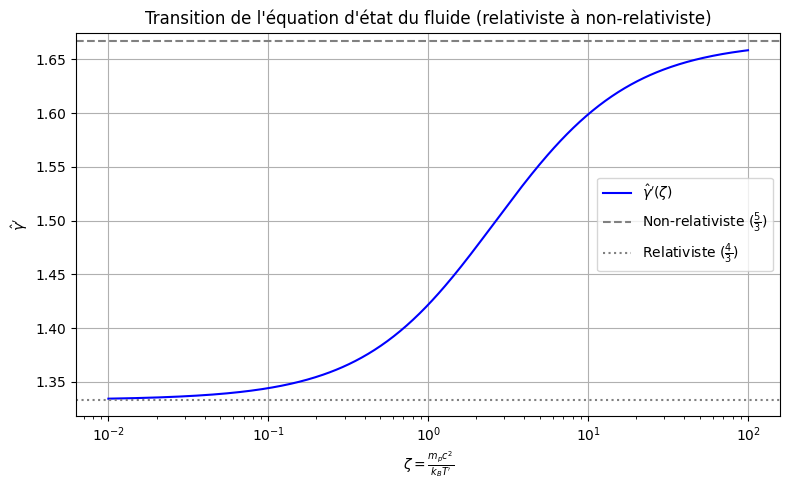

In [53]:
# Domaine de zeta : log de 1e-2 à 1e2
zeta_vals = np.logspace(-2, 2, 400)
gamma_vals = [jet.gamma_hat(z) for z in zeta_vals]

# Tracé
plt.figure(figsize=(8,5))
plt.plot(zeta_vals, gamma_vals, label=r'$\hat{\gamma}^\prime(\zeta)$', color='blue')
plt.axhline(5/3, color='gray', linestyle='--', label=r'Non-relativiste ($\frac{5}{3}$)')
plt.axhline(4/3, color='gray', linestyle=':', label=r'Relativiste ($\frac{4}{3}$)')

plt.xscale('log')
plt.xlabel(r'$\zeta = \frac{m_p c^2}{k_B T^\prime}$')
plt.ylabel(r'$\hat{\gamma}^\prime$')
plt.title("Transition de l'équation d'état du fluide (relativiste à non-relativiste)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<>:14: SyntaxWarning: invalid escape sequence '\z'
<>:14: SyntaxWarning: invalid escape sequence '\z'
C:\Users\Sourya\AppData\Local\Temp\ipykernel_37828\2483819023.py:14: SyntaxWarning: invalid escape sequence '\z'
  plt.title("Énergie interne spécifique du fluide relativiste en fonction de $\zeta$")


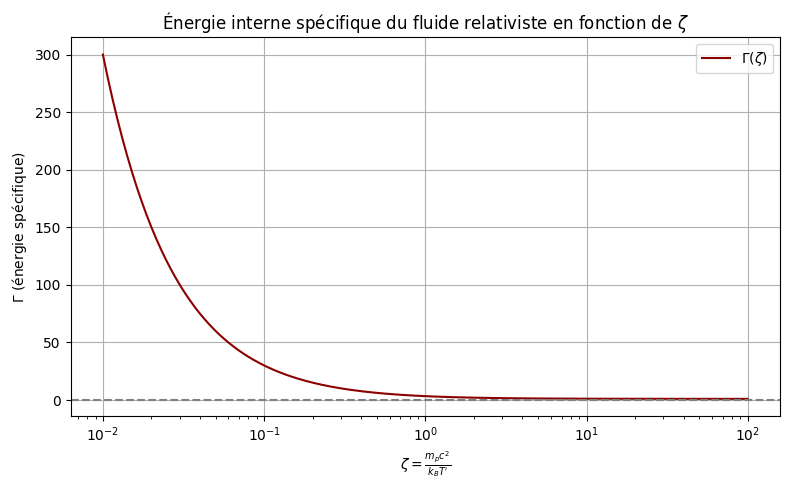

In [54]:
def Gamma_zeta(zeta):
    return Kv(3, zeta) / Kv(2, zeta) - 1 / zeta

# Domaine de zeta : log de 1e-2 à 1e2
zeta_vals = np.logspace(-2, 2, 400)
Gamma_vals = [Gamma_zeta(z) for z in zeta_vals]

# Tracé
plt.figure(figsize=(8,5))
plt.plot(zeta_vals, Gamma_vals, color='darkred', label=r'$\Gamma(\zeta)$')
plt.xscale('log')
plt.xlabel(r'$\zeta = \frac{m_p c^2}{k_B T^\prime}$')
plt.ylabel(r'$\Gamma$ (énergie spécifique)')
plt.title("Énergie interne spécifique du fluide relativiste en fonction de $\zeta$")
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()